# Capstone Project - The Battle of the Neighborhoods

### IBM Coursera Applied Data Science Course 

### By Kimberly Watada

## Introduction: Business Problem 

In this project we will try to find the optimal place to open a sushi restaurant in Toronto. The criteria for this location is:

1) The location is close to the center of Toronto to increase accessibility and customer volume  
2) There are few high ranked sushi restaurants nearby to reduce competition  
3) The existing stores in the neighborhood are popular, indicating a popular neighborhood

Using data science, the most promising neighborhoods will be evaluated and their information presented to stakeholders so they can make the decision as to the neighborhood that best suits them. 


## Data

Data on the location of different neighborhoods in Canada can be found <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">here</a>. Using a csv of the geospatial coordines, the latitude and longitude of each of these locations can be determined. These results can be narrowed down to find neighborhoods close to the center of Toronto, which will be assumed to be town hall.  

The FourSquare API will be used to retrieve the number of sushi restaurants located in each neighborhood. It will also be used to retrieve customer rankings on the businesses in close proximity and any further data needed for analysis of each neighborhood. 

## Finding Toronto Neighborhoods

In [281]:
import urllib.request 
from bs4 import BeautifulSoup
import pandas as pd

In [282]:
# website with list of Canadian postal codes and neighborhoods
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [283]:
page=urllib.request.urlopen(url)

In [284]:
# look at HTML code for table
soup=BeautifulSoup(page,"lxml")

In [285]:
# find all instances of the table tag
all_tables=soup.find_all("table")

In [286]:
#restrict table tag to specific class
right_table=soup.find('table',class_='wikitable sortable')

### Extract content from HTML data in 3 groups for the 3 columns
 

In [287]:
A=[]
B=[]
C=[]

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))


In [288]:
#remove newline characters
for code in range(len(A)):
    A[code]=A[code].rstrip()
    B[code]=B[code].rstrip()
    C[code]=C[code].rstrip()

In [289]:
#convert column lists to dataframe
df=pd.DataFrame(A,columns=["Postal Code"])
df['Borough']=B
df['Neighborhood']=C

In [290]:
df=df[df.Borough=="Downtown Toronto"]

In [291]:
df=df.reset_index(drop=True)

In [292]:
rows=df.shape[0]
print('number of rows: ' + str(rows))

number of rows: 19


In [293]:
#dataframe contains 19 neighborhoods within downtown Toronto
df.head()

,Postal Code,Borough,Neighborhood
0,M5A,Downtown Toronto,"Regent Park, Harbourfront"
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
2,M5B,Downtown Toronto,"Garden District, Ryerson"
3,M5C,Downtown Toronto,St. James Town
4,M5E,Downtown Toronto,Berczy Park


In [294]:
#import csv data to find latitude and longitude
df2=pd.read_csv("Geospatial_Coordinates.csv")
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [295]:
Lat=[]
Long=[]

for postal_code in df['Postal Code']:
    for postal_code2 in df2['Postal Code']:
        if postal_code==postal_code2:
            Lat.append(df2.loc[df2['Postal Code']==postal_code,'Latitude'].values[0])
            Long.append(df2.loc[df2['Postal Code']==postal_code,'Longitude'].values[0])


In [296]:
df["Latitude"]=Lat
df["Longitude"]=Long


In [297]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


### Calculate the distance between each neighborhood and city hall using the Haversine formula

In [298]:
#location of City Hall
cityhall_latitude=43.6532
cityhall_longitude=-79.383

In [299]:
import math
radius_earth=6373
lat1=math.radians(cityhall_latitude)
long1=math.radians(cityhall_longitude)

In [300]:
Distance=[]
for lat in df.Latitude:
    lat2=math.radians(lat)
    long2=math.radians(df.loc[df['Latitude']==lat,'Longitude'])
    dlat=lat1-lat2
    dlong=long1-long2
    a=math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlong / 2)**2
    b=2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist=radius_earth*b
    Distance.append(dist)

In [301]:
df["Distance from city hall (km)"]=Distance

In [302]:
df.sort_values(by=['Distance from city hall (km)'], axis=0,inplace=True)
df=df.reset_index(drop=True)

In [303]:
Points=[0]*df.shape[0]
for i in range(df.shape[0]):
    Points[i]=Points[i]+i

In [304]:
#define a points system where the lower the score the better the neighborhood
df['Score']=Points
print(Points)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [305]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance from city hall (km),Score
0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0.318454,0
1,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0.533808,1
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.548722,2
3,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0.612467,3
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.635466,4


## Determine the number of sushi restaurants in each neighborhood

In [306]:
import requests # library to handle requests
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library


In [307]:
CLIENT_ID = 'RXZJ5FXSYWCO4MJZIAAYQWAOVITVZSCES2QKHJXANRMUNWPQ' # your Foursquare ID
CLIENT_SECRET = '5KVGLAJKNYWTI5J4GSU15UOJDYLX0LTGQ5VEPFQDZ2VHHW3G' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RXZJ5FXSYWCO4MJZIAAYQWAOVITVZSCES2QKHJXANRMUNWPQ
CLIENT_SECRET:5KVGLAJKNYWTI5J4GSU15UOJDYLX0LTGQ5VEPFQDZ2VHHW3G


In [308]:
search_query = 'Japanese'
radius = 500
LIMIT = 30

In [309]:
neighborhoodDataframeDict=dict()
numberOfSushiVenues=[]
ids=[] # a list of all the venue ids in each neighborhood
for i in range(df.shape[0]):
    latitude=df.loc[i,"Latitude"]
    longitude=df.loc[i,"Longitude"]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    dataframe = json_normalize(venues)
    if 'id' in dataframe:
        ids.append(dataframe.id)
    else:
        ids.append('no venues')
    numberOfSushiVenues.append(dataframe.shape[0])
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.


In [310]:
df["Number of Other Sushi Venues"]=numberOfSushiVenues


In [311]:
df.sort_values(by=['Number of Other Sushi Venues'], axis=0,inplace=True)
df=df.reset_index(drop=True)
df



,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance from city hall (km),Score,Number of Other Sushi Venues
0,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3.665966,18,0
1,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2.850006,16,0
2,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,2.053917,15,0
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.803665,14,0
4,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2.965160,17,0
5,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,1.731445,13,1
6,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1.372098,10,1
7,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.219726,9,1
8,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.139276,8,2
9,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.639030,5,5


In [312]:
i=0
newScore=[]
for cell in df["Score"]:
    element=cell+i
    newScore.append(element)
    i=i+1
    

In [313]:
df['new Score']=newScore
df.drop(columns=['Score'],axis=1,inplace=True)
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance from city hall (km),Number of Other Sushi Venues,new Score
0,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3.665966,0,18
1,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2.850006,0,17
2,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,2.053917,0,17
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.803665,0,17
4,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2.965160,0,21
5,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,1.731445,1,18
6,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1.372098,1,16
7,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.219726,1,16
8,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.139276,2,16
9,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.639030,5,14


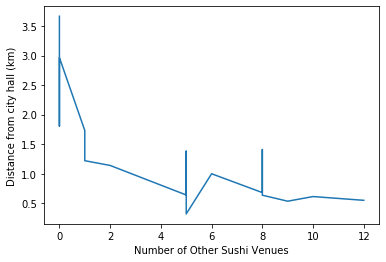

In [314]:
import matplotlib.pyplot as plt
plt.plot(df['Number of Other Sushi Venues'],df['Distance from city hall (km)'])
plt.ylabel("Distance from city hall (km)")
plt.xlabel("Number of Other Sushi Venues")
plt.show()
#there are a lot of sushi venues near city hall

### It seems that distance from city hall is inversely proportional to the number of sushi venues. The third criteria must act as a tie breaker.

### Find the average rating of sushi restaurants in each neighborhood

In [315]:
df.sort_values(by=['new Score'], axis=0,inplace=True)
df=df.reset_index(drop=True)

In [316]:
top_10=df.iloc[0:10] #narrow down dataframe to top ten
top_10

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance from city hall (km),Number of Other Sushi Venues,new Score
0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0.318454,5,11
1,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.639030,5,14
2,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1.372098,1,16
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.219726,1,16
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.139276,2,16
5,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2.850006,0,17
6,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,2.053917,0,17
7,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.803665,0,17
8,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0.533808,9,17
9,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3.665966,0,18


In [317]:
#analyze number M5H
search_query = 'Japanese'
radius = 500
print(search_query + ' .... OK!')


Japanese .... OK!


In [318]:
avg_ratings=[]

for neighborhood in ids[0:10]:
    neighborhood_ratings=[]
    for venue_id in neighborhood:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        if 'venue' in result['response'].keys():
            if 'rating' in result['response']['venue'].keys():
                neighborhood_ratings.append(result['response']['venue']['rating'])
   
    if len(neighborhood_ratings)==0:
        avg_ratings.append("No ratings")
    else:
        avg_ratings.append(sum(neighborhood_ratings)/len(neighborhood_ratings))  

In [320]:
avg_ratings

[6.699999999999999,
 6.7,
 6.871428571428573,
 6.95,
 6.540000000000001,
 6.840000000000001,
 6.449999999999999,
 7.016666666666667,
 5.35,
 8.0]

In [321]:
top_10["Average Existing Ratings"]=avg_ratings

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [327]:
top_10.sort_values(by=['Average Existing Ratings'], axis=0,inplace=True)
top_10=top_10.reset_index(drop=True)
top_10

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance from city hall (km),Number of Other Sushi Venues,new Score,Average Existing Ratings
0,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0.533808,9,17,5.350000
1,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,2.053917,0,17,6.450000
2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.139276,2,16,6.540000
3,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0.318454,5,11,6.700000
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.639030,5,14,6.700000
5,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2.850006,0,17,6.840000
6,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1.372098,1,16,6.871429
7,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.219726,1,16,6.950000
8,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.803665,0,17,7.016667
9,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3.665966,0,18,8.000000


A lower rating for the existing Japanese restaurant indicates less competition. All of these values are quite similar with the exception of Regent Park and Christie, which can be removed from contention. Otherwise, further analysis must be done to compare these locations.

In [331]:
top_8=top_10[0:8]
top_8.sort_values(by=['new Score'], axis=0,inplace=True)
top_8=top_8.reset_index(drop=True)
top_8

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance from city hall (km),Number of Other Sushi Venues,new Score,Average Existing Ratings
0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0.318454,5,11,6.700000
1,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.639030,5,14,6.700000
2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.139276,2,16,6.540000
3,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1.372098,1,16,6.871429
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.219726,1,16,6.950000
5,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0.533808,9,17,5.350000
6,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,2.053917,0,17,6.450000
7,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2.850006,0,17,6.840000


### Find the trending venues in each area

In [280]:
for i in range(0,10):
    latitude=df.loc[i,"Latitude"]
    longitude=df.loc[i,"Longitude"]
    url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)
    # send GET request and get trending venues
    results = requests.get(url).json()
    if len(results['response']['venues']) == 0:
        trending_venues_df = 'No trending venues are available at the moment!'
    
    else:
        trending_venues = results['response']['venues']
        trending_venues_df = json_normalize(trending_venues)

        # filter columns
        columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
        trending_venues_df = trending_venues_df.loc[:, columns_filtered]

        # filter the category for each row
        trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)
        
    print(trending_venues_df)

    
    

No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!
No trending venues are available at the moment!


Due to the current COVID-19 pandemic, it makes sense that there are no trending restaurants at the moment. Since Foursquare does not have data on the popularity of these values, another method must be used to visualize the advantages of each neighborhood.

### Plotting each neighborhood and Japanese restaurants in Folium

### Compile the latitude and longitude data

In [224]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [225]:
#get venue data for neighborhood 1 
latitude0=df.loc[0,"Latitude"]
longitude0=df.loc[0,"Longitude"]
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude0, longitude0, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered0 = dataframe.loc[:, filtered_columns]


# filter the category for each row
dataframe_filtered0['categories'] = dataframe_filtered0.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered0.columns = [column.split('.')[-1] for column in dataframe_filtered0.columns]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [226]:
#get venue data for neighborhood 2
latitude1=df.loc[1,"Latitude"]
longitude1=df.loc[1,"Longitude"]
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude1, longitude1, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered1 = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered1['categories'] = dataframe_filtered1.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered1.columns = [column.split('.')[-1] for column in dataframe_filtered1.columns]
dataframe_filtered1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,neighborhood,id
0,Bikkuri Japanese,Sushi Restaurant,36 King St. E,at Victoria,43.649564,-79.376328,"[{'label': 'display', 'lat': 43.649564308142, ...",226,CA,Toronto,ON,Canada,"[36 King St. E (at Victoria), Toronto ON, Canada]",NaN,NaN,4af63562f964a5203d0222e3
1,Gyu-Kaku Japanese BBQ,Japanese Restaurant,81 Church St,at Adelaide St E,43.651422,-79.375047,"[{'label': 'display', 'lat': 43.65142227549791...",30,CA,Toronto,ON,Canada,"[81 Church St (at Adelaide St E), Toronto ON M...",M5C 2G2,NaN,574ad72238fa943556d93b8e
2,Sakura Ichiban Japanese Cuisine,Japanese Restaurant,142 Adelaide St. E.,NaN,43.651624,-79.372464,"[{'label': 'display', 'lat': 43.65162413928149...",238,CA,Toronto,ON,Canada,"[142 Adelaide St. E., Toronto ON M5C 1K9, Canada]",M5C 1K9,NaN,4b4b60e5f964a520619926e3
3,NAMI,Japanese Restaurant,55 Adelaide Street East,at Church street,43.650853,-79.375887,"[{'label': 'display', 'lat': 43.65085336178512...",80,CA,Toronto,ON,Canada,"[55 Adelaide Street East (at Church street), T...",M5C 1K6,NaN,4b999927f964a5207c8635e3
4,Ninki Sushi,Japanese Restaurant,40 King St W,at Bay St,43.649812,-79.379518,"[{'label': 'display', 'lat': 43.64981217424400...",379,CA,Toronto,ON,Canada,"[40 King St W (at Bay St), Toronto ON M5H 1A1,...",M5H 1A1,Financial District,4beb2c0ba9900f475b7a1740


In [227]:
#get venue data for neighborhood 3
latitude2=df.loc[2,"Latitude"]
longitude2=df.loc[2,"Longitude"]
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude2, longitude2, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered2 = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]
dataframe_filtered2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Aji Sai Japanese Restaurant,Sushi Restaurant,467 Queen St. W.,at Spadina Ave.,43.648498,-79.397469,"[{'label': 'display', 'lat': 43.64849829452195...",563,M5V 2A9,CA,Toronto,ON,Canada,"[467 Queen St. W. (at Spadina Ave.), Toronto O...",4adf4011f964a520b97821e3


In [228]:
#get venue data for neighborhood 4
latitude3=df.loc[3,"Latitude"]
longitude3=df.loc[3,"Longitude"]
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude3, longitude3, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered3 = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered3['categories'] = dataframe_filtered3.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered3.columns = [column.split('.')[-1] for column in dataframe_filtered3.columns]
dataframe_filtered3

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Ki Modern Japanese + Bar,Japanese Restaurant,181 Bay St,at Wellington St. W,43.647223,-79.379374,"[{'label': 'display', 'lat': 43.647223, 'lng':...",559,M5J 2T3,CA,Toronto,ON,Canada,"[181 Bay St (at Wellington St. W), Toronto ON ...",4ae73054f964a5203ca921e3


In [229]:
#get venue data for neighborhood 5
latitude4=df.loc[4,"Latitude"]
longitude4=df.loc[4,"Longitude"]
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude4, longitude4, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered4 = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered4['categories'] = dataframe_filtered4.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered4.columns = [column.split('.')[-1] for column in dataframe_filtered4.columns]
dataframe_filtered4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,postalCode,id
0,Kenzo Japanese Noodle House,Ramen Restaurant,522 Yonge St,btwn Breadalbane & Grosvenor,43.663702,-79.384053,"[{'label': 'display', 'lat': 43.66370201195534...",465,CA,Toronto,ON,Canada,"[522 Yonge St (btwn Breadalbane & Grosvenor), ...",NaN,4ea341925c5cd12b3601d654
1,Sushi Sky,Sushi Restaurant,478 Yonge St.,NaN,43.662446,-79.383604,"[{'label': 'display', 'lat': 43.66244625914365...",474,CA,Toronto,ON,Canada,"[478 Yonge St., Toronto ON M4Y 1X5, Canada]",M4Y 1X5,4b5c7d3cf964a520653229e3


### Map the top four neighborhoods and the nearby Japanese restaurants using Folium

In [338]:
#coordinates of city hall
latitude=43.6532
longitude=-79.383

venues_map = folium.Map(location=[latitude, longitude], zoom_start=14)

folium.features.CircleMarker(
    [latitude, longitude],
    radius=20,
    color='pink',
    popup='City Hall',
    fill = True,
    fill_color = 'pink',
    fill_opacity = 0.6
).add_to(venues_map)

#first neighborhood

folium.features.CircleMarker(
    [latitude0, longitude0],
    radius=10,
    color='red',
    popup='Richmond, Adelaide, King',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered0.lat, dataframe_filtered0.lng, dataframe_filtered0.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# Second neighborhood
folium.features.CircleMarker(
    [latitude1, longitude1],
    radius=10,
    color='green',
    popup='St. James Town',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered1.lat, dataframe_filtered1.lng, dataframe_filtered1.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
# Third neighborhood
folium.features.CircleMarker(
    [latitude2, longitude2],
    radius=10,
    color='yellow',
    popup='Kensington',
    fill = True,
    fill_color = 'yellow',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered2.lat, dataframe_filtered2.lng, dataframe_filtered2.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

#fourth neighborhood

folium.features.CircleMarker(
    [latitude3, longitude3],
    radius=10,
    color='purple',
    popup='Berczy Park',
    fill = True,
    fill_color = 'purple',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered3.lat, dataframe_filtered3.lng, dataframe_filtered3.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='purple',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
#fifth neighborhood

folium.features.CircleMarker(
    [latitude4, longitude4],
    radius=10,
    color='orange',
    popup='Queens Park',
    fill = True,
    fill_color = 'orange',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered4.lat, dataframe_filtered4.lng, dataframe_filtered4.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='orange',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
display(venues_map)

Upon inspection, it is clear that Richmond and St. James Town are surrounded by other sushi venues, but are in close proximity to the city center. In contrast, Kensington and Queen's Park are farther away but have less competition. Berczy Park seems to respresent a middle ground, as it has little competition, and is a moderate distance away from the city core. Its location is close to Union Station, which sees lots of pedestrian traffic. Further research done on the area shows that it is a very popular spot for walking and eating close to the waterfront. 

## Conclusion


In conclusion, Berczy Park is the recommended location to open a Japanese restaurant. This is because the low number of nearby Japanese restaurants numbers indicates there would be little competition in the area. Furthermore, there is great potential for customers due to the popularity of the area. 

The Foursquare API provided limited information in terms of customer tips and trends within the area. Therefore, for future studies, it is recommended areas are explored in even greater detail to determine other areas that could benefit restaurant owners.
